In [1]:
# imports
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama 
from IPython.display import Image, display



# Graf

```
[START]
   ↓
[user_input (+ image)] 
   ↓
 `query_analysis_node`
   ↓        ↓            ↓
[analyze_image]   [retrieval]   [llm_generation]
   ↓                  ↓               ↑
[retrieval]       [llm_generation]    |
   ↓                  ↓               |
[llm_generation] <----
   ↓
[generate_summary]
   ↓
[END]

```

1. Add Image processing, as a Node with will return probability of belongig to a given class with and class
2. RAG (retrieval) 
3. LLM response
3. Converstation Summarization 
3. Smart query routing




In [2]:
# add model, embedding model, vectorestore and retriever, text splitter ,  

# LLMs

In [29]:
model = ChatOllama(model="llama3.2:latest", temperature=0.1)
embedings = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")

# Prompts

In [40]:
template = '''
# Role
You are a medical AI assistant focused on Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system.
Your primary goal is to provide precise answers based on the given context, image analysis, or chat history.

# Instruction
Provide a concise, logical answer by organizing the selected content into coherent paragraphs with a natural flow. 
Avoid merely listing information. Include key numerical values, technical terms, jargon, and names. 
DO NOT use any outside knowledge or information that is not in the given material.

# Constraint
- Review the provided context and image analysis thoroughly and extract key details related to the question.
- Craft a precise answer based on the relevant information.
- Keep the answer concise but logical/natural/in-depth.
- If the retrieved context does not contain relevant information or no context is available, respond with: 'I can't find the answer to that question in the context.'

**Source** (Optional)
- Cite the source of the information as a file name with a page number or URL, omitting the source if it cannot be identified.
- (list more if there are multiple sources)

# Question
<question>
{question}
</question>

# Image Analysis
<image_analysis>
The image has been classified as: {predicted_class}
Prediction confidence: {confidence:.2%}
</image_analysis>

# Context
<retrieved context>
{context}
</retrieved context>

# Answer
'''

# Create Index

In [21]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
import bs4

web_paths = ['https://medlineplus.gov/ency/article/000033.html',
             'https://pmc.ncbi.nlm.nih.gov/articles/PMC10503338/',
             'https://www.ncbi.nlm.nih.gov/books/NBK537235/',
             'https://medicaljournalssweden.se/actadv/article/view/11592/19144',
             'https://emedicine.medscape.com/article/769067-overview?form=fpf',
             'https://www.mayoclinic.org/first-aid/first-aid-insect-bites/basics/art-20056593',
             'https://www.medicalnewstoday.com/articles/174229#reactions',
             'https://www.aafp.org/pubs/afp/issues/2022/0800/arthropod-bites-stings.html',
             'https://wwwnc.cdc.gov/travel/page/avoid-bug-bites']

loader = WebBaseLoader(
    web_paths=web_paths,
    bs_kwargs = dict(
        parse_only = bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

documents = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=100,
                                         chunk_overlap=50,
                                         add_start_index=True)

all_splits = splitter.split_documents(documents)

vectorstores = FAISS.from_documents(documents=all_splits,
                                    embedding=embedings)

retriver = vectorstores.as_retriever()

In [44]:
def retrive(state):

    print("---RETRIVE---")
    
    prediction = state.get("image_metadata", {})
    question = state.get("question")
    cls = prediction.get("predicted_class")
    conf = prediction.get("prediction_confidences")


    query = f"""The user asked: "{question}".
            This question relates to a medical image classified as: {cls}"""
    
    print(f"Retrieval query: {query}")
    
    documents = retriver.invoke(query)
    
    return {
        "retrived_docs" : [documents]
    }
    

# Image processing

In [45]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


model_path = r"E:\Deep_Learning\Skin diseases\best_model.h5"
model_cv = load_model(model_path)

BATCH_SIZE = 64
IMAGE_SIZE = 150
channels = 3
classes = ['Bite', 'Healthy Skin', 'Wound']

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError(f"Image not loaded correctly from path: {image_path}")
        
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, channels)
    img = img / 255.0
    
    return img


def analyze_image_node(state):
    print("---IMAGE ANALYSIS---")
    
    image_path = state.get("image", "")

    if not image_path:
        raise ValueError("No image path provided in state")

    # Preprocess + prediction
    img = preprocess_image(image_path)
    prediction = model_cv.predict(img)
    
    confidences = {cls: float(conf) for cls, conf in zip(classes, prediction[0])}
    predicted_class = max(confidences, key=confidences.get)

    return {
        "image_metadata": {
            "predicted_class": predicted_class,
            "prediction_confidences": confidences
        }
    }



# Generate Response

In [46]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def generate_response(state):
    print("---GENERATION OF RESPONSE---")

    
    prediction = state.get("image_metadata", {})
    cls = prediction.get("predicted_class")
    conf = prediction.get("prediction_confidences", {}).get(cls, 0)

    question = state['question']
    retrived_docs = state.get("retrived_docs")
    prompt = ChatPromptTemplate.from_template(template)
    
    rag_chain = prompt | model | StrOutputParser()
    response = rag_chain.invoke({"question" : question , "context" : retrived_docs , "predicted_class" : cls , "confidence" : conf})
    
    return {
        "answer": [response]
    }

# Graph State

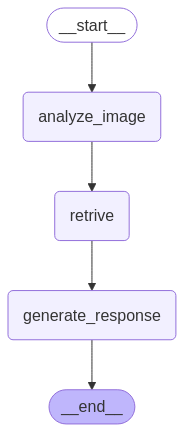

In [47]:
from langgraph.prebuilt import ToolNode ,tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict , Annotated
from langchain_core.messages import AIMessage, AnyMessage, HumanMessage, SystemMessage, RemoveMessage
from langgraph.graph.message import add_messages


class MedicalAssistantState(TypedDict):
    image: str
    image_metadata: dict
    question: str
    answer: str
    retrived_docs : list

    
builder = StateGraph(MedicalAssistantState)

builder.add_node("analyze_image", analyze_image_node,)
builder.add_node("generate_response", generate_response)
builder.add_node("retrive" , retrive)

builder.add_edge(START, "analyze_image")
builder.add_edge("analyze_image", "retrive")
builder.add_edge("retrive", "generate_response")
builder.add_edge("generate_response", END)

medical_assistant = builder.compile()

display(Image(medical_assistant.get_graph().draw_mermaid_png()))

In [51]:
img_path = r"E:\Deep_Learning\Skin diseases\data_wbh\train\Wound\Cut\cut (2).jpg"

response = medical_assistant.invoke({"image" : img_path , "question" : "What happened to my hand ?"})
print(response)

---IMAGE ANALYSIS---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
---RETRIVE---
Retrieval query: The user asked: "What happened to my hand ?".
            This question relates to a medical image classified as: Wound
---GENERATION OF RESPONSE---
{'image': 'E:\\Deep_Learning\\Skin diseases\\data_wbh\\train\\Wound\\Cut\\cut (2).jpg', 'image_metadata': {'predicted_class': 'Wound', 'prediction_confidences': {'Bite': 2.2537615222972818e-06, 'Healthy Skin': 0.00012671222793869674, 'Wound': 0.999871015548706}}, 'question': 'What happened to my hand ?', 'answer': ["Based on the provided context and image analysis, I can attempt to provide a logical answer.\n\nGiven that the image has been classified as a Wound with a high prediction confidence of 99.99%, it is likely that your hand has sustained some form of injury or trauma resulting in this wound.\n\nThe retrieved context appears to be related to medical articles and licenses for distribution, but none of these sources directly address the question

In [52]:
for m in response['answer']:
    print(m) 

Based on the provided context and image analysis, I can attempt to provide a logical answer.

Given that the image has been classified as a Wound with a high prediction confidence of 99.99%, it is likely that your hand has sustained some form of injury or trauma resulting in this wound.

The retrieved context appears to be related to medical articles and licenses for distribution, but none of these sources directly address the question of what happened to your hand. However, I can suggest that you may want to consult a medical professional for an accurate diagnosis and treatment plan.

If you're experiencing pain or discomfort in your hand, it's essential to seek medical attention as soon as possible. A healthcare provider can assess the wound, provide guidance on proper care and treatment, and help determine the cause of the injury.

I recommend visiting an emergency room or scheduling an appointment with a primary care physician for further evaluation and advice.

Please note that th

In [53]:
print(response['image_metadata'])

{'predicted_class': 'Wound', 'prediction_confidences': {'Bite': 2.2537615222972818e-06, 'Healthy Skin': 0.00012671222793869674, 'Wound': 0.999871015548706}}
